### Data Download

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports the warnings module from the Python standard library
import warnings

# Configuration to ignore all warnings that are generated during the execution of the code
warnings.filterwarnings('ignore')

# Imports the clear_output function from the IPython.core.display module
from IPython.core.display import clear_output

clear_output()

In [4]:
# Imports the NumPy library
import numpy as np

# Imports the Pandas library
import pandas as pd

# Imports the pyplot module of Matplotlib library
import matplotlib.pyplot as plt

# Imports the StandardScaler class from the sklearn.preprocessing module
from sklearn.preprocessing import StandardScaler

# Imports the train_test_split function from the sklearn.model_selection module
from sklearn.model_selection import train_test_split

# Imports three functions from the sklearn.metrics module: accuracy_score, confusion_matrix, and classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
# Imports the PyTorch library
import torch

# Imports the torch.nn module
import torch.nn as nn

# Imports the torch.optim module
import torch.optim as optim

# Imports two classes from the torch.utils.data module: DataLoader and TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [6]:
# The kaggle competitions download command is used to download a dataset from a Kaggle competition
# !kaggle competitions download -c uciml/iris -p ../Data/
!kaggle datasets download uciml/iris -p ../Data/

Dataset URL: https://www.kaggle.com/datasets/uciml/iris
License(s): CC0-1.0
iris.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Imports the zipfile module
import zipfile

# Opens the ZIP file in read-only mode and assign it to the variable zip_ref
# The with statement is used to ensure that the file is properly closed after use
with zipfile.ZipFile('../Data/iris.zip', 'r') as zip_ref:

    # Extracts all the files from the ZIP archive and saves them to the specified directory
    zip_ref.extractall('../Data/')

In [8]:
# Imports the Path class from the pathlib module
from pathlib import Path

# The posix path of the data and models are assigned to the corresponding variables
data_path = Path('../Data/')
model_path = Path('../Models/NN/')

# Data Exploration

In [9]:
# Reads the 'test.csv' file and saves as a DataFrame object
df_org = pd.read_csv(data_path/'iris.csv')

In [10]:
# Copies the original DataFrame object to another 
df = df_org.copy()

In [11]:
# Shows the top five rows of the DataFrame holding the training data
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [13]:
df.nunique()

Id               150
SepalLengthCm     35
SepalWidthCm      23
PetalLengthCm     43
PetalWidthCm      22
Species            3
dtype: int64

In [14]:
df.isna().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [15]:
df = df.drop("Id", axis=1)

In [16]:
def plot_columns(df:pd.DataFrame, cols:list):
    # Checkinge distributions of the numeric columns.
    for col in cols:
        column = df[col]
        min_val = column.min()
        max_val = column.max()
        skew = column.skew()
        mean = column.mean()
        
        plt.figure(figsize=(8, 4))
        plt.title(col)
        plt.ylabel('Count')
        
        print(f"min:{min_val} | max: {max_val} | skew: {skew} | mean: {mean}")
        
        df[col].plot(kind='kde')

        plt.show()

min:4.3 | max: 7.9 | skew: 0.3149109566369728 | mean: 5.843333333333334


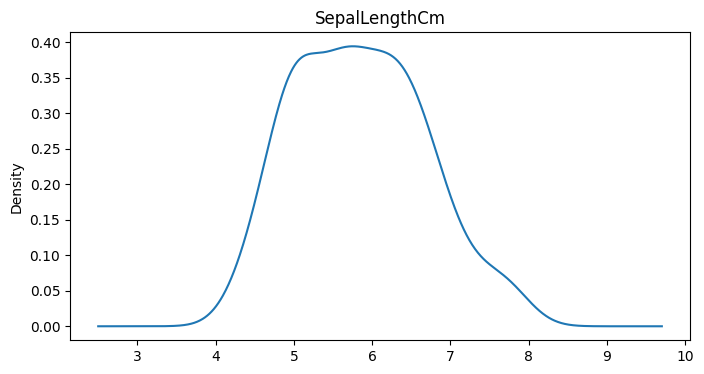

min:2.0 | max: 4.4 | skew: 0.3340526621720866 | mean: 3.0540000000000003


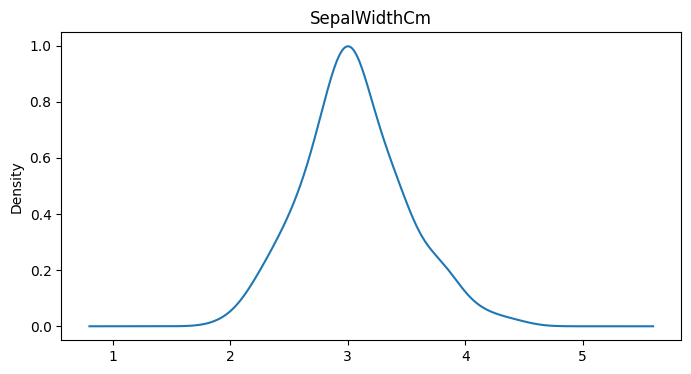

min:1.0 | max: 6.9 | skew: -0.27446425247378287 | mean: 3.758666666666666


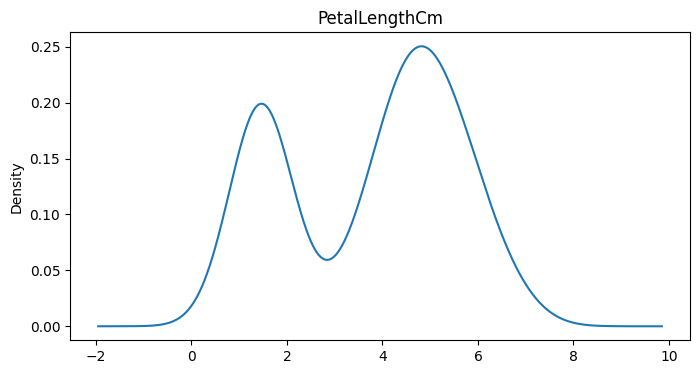

min:0.1 | max: 2.5 | skew: -0.10499656214412734 | mean: 1.1986666666666668


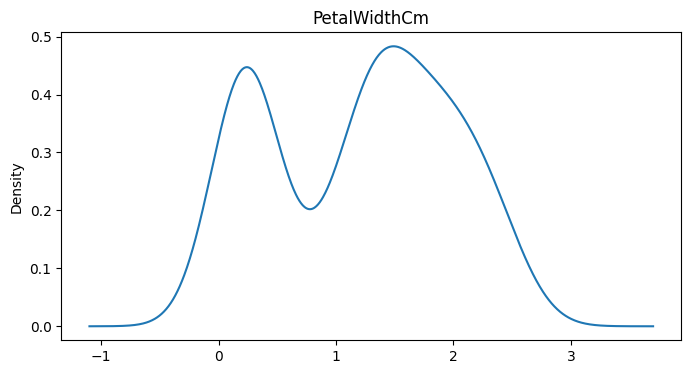

In [17]:
plot_columns(df, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"])

In [18]:
df.isna().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [19]:
def remove_anomalies(df:pd.DataFrame, cols:list, multiplier=1.5)->pd.DataFrame:
    """Remove outliers from a data frame for selective columns

    Args:
        df (pd.DataFrame): The data frame to be altered
        column_names (list): list of column names to be operated on

    Returns:
        pd.DataFrame: The modified data frame after removing the outliers
    """
    for col in cols:
        null_df = df[df[col].isna()]
        
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)

        IQR = Q3 - Q1

        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        df = pd.concat([df, null_df])
        
    return df

In [20]:
df = remove_anomalies(df, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"])

In [21]:
df.isna().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [22]:
def normalize(data_frame:pd.DataFrame, cols:list)->pd.DataFrame:
    """Normalize selective columns of a data frame

    Args:
        data_frame (pd.DataFrame): The data frame to be altered
        column_names (list): list of column names to be normalized

    Returns:
        pd.DataFrame: The modified data frame with normalized columns
    """
    normalizer = StandardScaler()
    data_frame[cols] = normalizer.fit_transform(data_frame[cols])

    return data_frame

In [23]:
df = normalize(df, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"])

In [24]:
df.isna().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [25]:
def discretize_features(data_frame: pd.DataFrame, col, bins:list, labels:list)->pd.DataFrame:
    """Discretize column into fixed sized bins

    Args:
        data_frame (pd.DataFrame): The data frame to be altered

    Returns:
        pd.DataFrame: The modified data frame with new column
    """
    # Discretize the column using the pd.cut() function
    data_frame[col] = pd.cut(data_frame[col], bins=bins, labels=labels)

    return data_frame

In [26]:
# df = discretize_features(df, "SepalLengthCm", [4.3, 4.9, 5.5, 6.1, 6.7, 7.3, 8], ["size1", "Size2", "size3", "size4", "size5", "size6"])
# df = discretize_features(df, "SepalWidthCm", [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5], ["size1", "Size2", "size3", "size4", "size5", "size6"])
# df = discretize_features(df, "PetalLengthCm", [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], ["size1", "Size2", "size3", "size4", "size5", "size6", "size7"])
# df = discretize_features(df, "PetalWidthCm", [0.0, 0.5, 1.0, 1.5, 2.0, 2.5], ["size1", "Size2", "size3", "size4", "size5"])

In [27]:
df.isna().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [28]:
# df["SepalLengthCm"].fillna(df["SepalLengthCm"].mode()[0], inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [30]:
def string_to_int(df:pd.DataFrame, col:str, mapper:dict)->pd.DataFrame:
    """AI is creating summary for bool_to_binary

    Args:
        df (pd.DataFrame): [description]
        cols (list): [description]

    Returns:
        pd.DataFrame: [description]
    """
    df[col] = df[col].astype(str)
    df[col] = df[col].map(mapper)
    return df

In [31]:
df["Species"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [32]:
df = string_to_int(df, "Species", dict({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}))

In [33]:
df["Species"].unique()

array([0, 1, 2])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 7.0 KB


In [35]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.900681,1.032057,-1.341272,-1.312977,0
1,-1.143017,-0.124958,-1.341272,-1.312977,0
2,-1.385353,0.337848,-1.398138,-1.312977,0
3,-1.506521,0.106445,-1.284407,-1.312977,0
4,-1.021849,1.263460,-1.341272,-1.312977,0


In [36]:
df.to_csv(data_path/"df_processed.csv", index=False)

# Training of a Feedforward Neural network for Multi-class Classification

In [37]:
df = pd.read_csv(data_path/"df_processed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [38]:
y = df["Species"].astype(int)
X = df.drop(["Species"], axis = 1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [41]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((107, 4), (23, 4), (20, 4), (107,), (23,), (20,))

In [42]:
class IrisDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [43]:
class NNMulticlassClassifier(nn.Module):
    def __init__(self, input_size):
        super(NNMulticlassClassifier, self).__init__()
        self.input_size = input_size
        self.model = nn.Sequential(
            nn.Linear(self.input_size, 64), 
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.Dropout(0.5), 
            nn.Linear(64, 128), 
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            # nn.Linear(128, 256), 
            # nn.BatchNorm1d(256), 
            # nn.ReLU(), 
            # nn.Dropout(0.5),
            # nn.Linear(256, 128), 
            # nn.BatchNorm1d(128), 
            # nn.ReLU(), 
            # nn.Dropout(0.5),
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            # nn.Linear(64, 32), 
            # nn.BatchNorm1d(32), 
            # nn.ReLU(), 
            # nn.Dropout(0.5),
            # nn.Linear(32, 16), 
            # nn.BatchNorm1d(16), 
            # nn.ReLU(), 
            # nn.Dropout(0.5),
            # nn.Linear(16, 8), 
            # nn.BatchNorm1d(8), 
            # nn.ReLU(), 
            # nn.Dropout(0.5),
            nn.Linear(64, 3), 
            nn.ReLU()
        )

    def forward(self, data):
        output = self.model(data)
        return output

In [44]:
multiClf = NNMulticlassClassifier(X_train.shape[1])


In [45]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

In [46]:
X_train_tensor.shape, X_test_tensor.shape, X_val_tensor.shape, y_train_tensor.shape, y_test_tensor.shape, y_val_tensor.shape

(torch.Size([107, 4]),
 torch.Size([23, 4]),
 torch.Size([20, 4]),
 torch.Size([107]),
 torch.Size([23]),
 torch.Size([20]))

In [47]:
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(multiClf.parameters(), lr = 0.0001)
epochs = 1500
bs = 4

In [48]:
train_dataset = IrisDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

val_dataset = IrisDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

test_dataset = IrisDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [49]:
train_loss = []
model_accuracy = []

for epoch in range(epochs):
    multiClf.train()
    epoch_train_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        batch_y_hat = multiClf(batch_X)
        batch_loss = criterion(batch_y_hat, batch_y)
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_loader)

    if epoch % 20 == 0:
        correct_preds = 0
        total_preds = 0
        multiClf.eval()
        with torch.no_grad():
            for val_batch_X, val_batch_y in val_loader:
                val_batch_y_hat = multiClf(val_batch_X)
                # import pdb; pdb.set_trace();
                _, pred = torch.max(val_batch_y_hat.data, 1)
                # _, actual_labels = torch.max(val_batch_y.data, 1)
                total_preds += val_batch_y.size(0)
                correct_preds += (pred == val_batch_y).sum().item()
        epoch_accuracy = correct_preds/total_preds
        train_loss.append(epoch_train_loss)
        model_accuracy.append(epoch_accuracy)

        print(f"After epoch {epoch}, train loss : {epoch_train_loss},  model accuracy : {int(epoch_accuracy*100)}%.")

After epoch 0, train loss : 1.1200505848284121,  model accuracy : 65%.
After epoch 20, train loss : 0.9769074674005862,  model accuracy : 70%.
After epoch 40, train loss : 0.902168454947295,  model accuracy : 90%.
After epoch 60, train loss : 0.8413064546055264,  model accuracy : 90%.
After epoch 80, train loss : 0.7670508910108496,  model accuracy : 90%.
After epoch 100, train loss : 0.8168046286812535,  model accuracy : 90%.
After epoch 120, train loss : 0.7739451715239772,  model accuracy : 90%.
After epoch 140, train loss : 0.7571184668276045,  model accuracy : 90%.
After epoch 160, train loss : 0.7514128353860643,  model accuracy : 90%.
After epoch 180, train loss : 0.6776956485377418,  model accuracy : 95%.
After epoch 200, train loss : 0.6197192370891571,  model accuracy : 95%.
After epoch 220, train loss : 0.6861667975231454,  model accuracy : 90%.
After epoch 240, train loss : 0.6158568185788614,  model accuracy : 90%.
After epoch 260, train loss : 0.6690094283333531,  model a

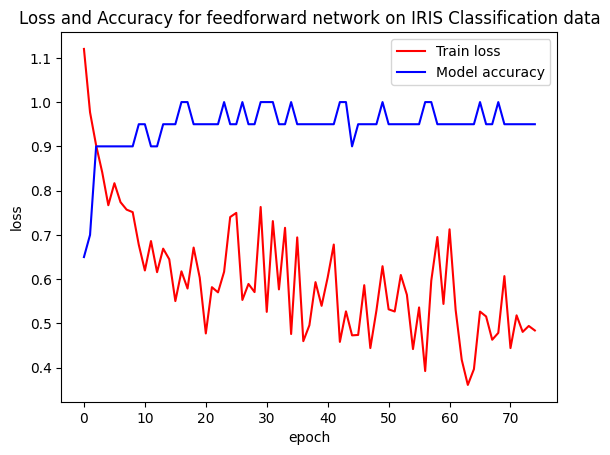

In [50]:
plt.plot(train_loss, label="Train loss", color="red")
plt.plot(model_accuracy, label="Model accuracy", color='blue')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss and Accuracy for feedforward network on IRIS Classification data")
plt.legend()
plt.show()

In [51]:
torch.save(multiClf.state_dict(), model_path)

# Test Set Prediction

In [52]:
# multiClf2 = NNMulticlassClassifier(X_train.shape[1])
# multiClf2.load_state_dict(torch.load(model_path))

In [53]:
# multiClf2.eval()

In [54]:
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# with torch.no_grad():
#     y_hat_logits = multiClf2(X_test_tensor)